In [2153]:
import numpy as np
import math

In [2154]:
def f(x):
    return 3*x**2 - 4*x + 5

x = np.arange(-5,5,0.25)

y = f(x)
y

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

In [2155]:
import matplotlib.pyplot as plt

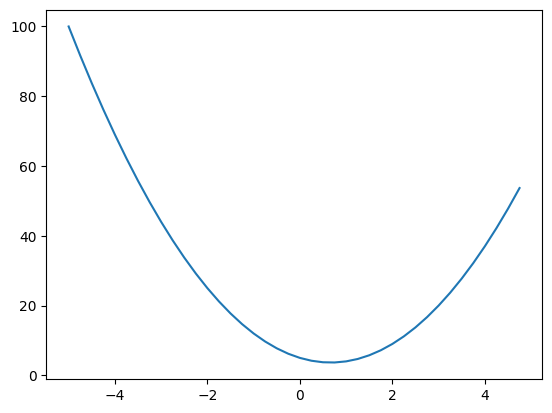

In [2156]:
# 展示一维函数的x轴的变化导致y轴的变化
plt.plot(x,y)

In [2157]:
f(5.0)

60.0

In [2158]:
# derivative means senstive of function in that point, bigger positive means slope x a little distance makes fucntion become bigger
# 导数的定义是什么
# 从数学公式上来说，在x某一点的导数等于如下dx的公式，h取极限0
# 定义上x在某一点的导数为：x向正方向增大极微小的数值时，对应结果y值的变化程度，直观上理解为函数的敏感度，英文（from video karpathy）：sensitive
# 可以由此想象，当某点的x增加了极微小的h时，对应的y值变化的非常大，那么可以确定的是，在该点函数是极其敏感的，对应可以说x在该点的变化将会引发函数结果y值的大幅波动
# 那么在数学上就是该点x的导数的绝对值一定具有比较大的值
# 如果在该点上x向正方向增加极微小h值导致函数结果y值增加，那么该点的导数就会相应的是正值，在二维图像上看该点的函数曲线是上升状态
# 如果在该点上x向正方向增加极微小h值导致函数结果y值减小，那么该点的导数就会相应的是负值，在二维图像上看该点的函数曲线是下降状态
# 如果在某一点x的导数为0，意味着函数在该点x的正方向增加极小标量的h将不会影响函数的结果y值，从直觉来说即函数在该点没有敏感度，不会变化，在图像上看该点必定是函数的极值点
# 导数为0意味着极大值或者极小值

# 应用公式求a在3.0点时的导数近似值
h = 0.01
a=3.0
def dx(a):
    return (f(a+h)-f(a))/h
dx(a)

14.029999999999632

In [2159]:
a=-2.0
print(f"dx(a)={dx(a)}")
print(f"f(a)={f(a)}")
print(f"f(a={a})={f(-a)}")
f(a)+0.01*dx(a)

dx(a)=-15.970000000000084
f(a)=25.0
f(a=-2.0)=9.0


24.8403

In [2160]:
# 导数极值点
dx(2/3)

0.02999999999997449

In [2161]:
h = 0.001

#inputs
a=2.0
b=-3.0
c=10.0

d1 = a*b+c
a+=h
d2 = a*b+c
print("d1:",d1)
print("d2:",d2)
print("slop:",(d2-d1)/h)

d1: 4.0
d2: 3.997
slop: -3.0000000000001137


In [2162]:
class Value_with_no_accumulate_grad:
    def __init__(self,data,_children=(),_op="",label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad=0
        self._backward = lambda: None
    # help print something better
    def __repr__(self):
        return f"Value(data={self.data})"
    # override operation + ,it will use a.__add__(b)
    def __add__(self,other):
        out = Value(self.data+other.data,(self,other),"+")
        def backward():
            self.grad = 1.0*out.grad
            other.grad = 1.0*out.grad
        self._backward = backward
        if(isinstance(other,float)):
            return Value(self.data+other,(self,other),"+")
        return out
    def __mul__(self,other):
        out = Value(self.data*other.data,(self,other),"*")
        def backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
        self._backward = backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        def backward():
            self.grad = 1-t**2
        self._backward = backward
        return Value(t,(self,),'tanh')
    def backward(self):
        topo = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                topo.append(node)
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
        self.grad = 1
        build_topo(self)
        for node in topo:
            node._backward()
        

In [2163]:
# 构造 Value 数据类型用来存储数据的变化跟踪
class Value:
    def __init__(self,data,_children=(),_op="",label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad=0
        self._backward = lambda: None
    # help print something better
    def __repr__(self):
        if(self.label):
            return f"Value(label={self.label}  data={self.data})"
        else:
            return f"Value(data={self.data})"
    # override operation + ,it will use a.__add__(b)
    def __add__(self,other):
        if(not isinstance(other,Value)):
            other = Value(other)
        out = Value(self.data+other.data,(self,other),"+")
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out
    def __radd__(self,other):
        return self.__add__(other)
    def __mul__(self,other):
        if(not isinstance(other,Value)):
             other = Value(other)
        out = Value(self.data*other.data,(self,other),"*")
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    def __rmul__(self, other):
        return self.__mul__(other)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += 1-t**2
        out._backward = _backward
        return out
        
    def exp(self):
        out = Value(math.exp(self.data),(self,),'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        
    def __sub__(self,other):
        if(not isinstance(other,Value)):
            other = Value(other)
        out = Value(self.data-other.data,(self,other),'-')
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out
        
    def __pow__(self,other):
        out = Value(self.data**other,(self,),'pow')
        def _backward():
            self.grad += other*self.data**(other-1)*out.grad
        out._backward = _backward
        return out
        
    def __truediv__(self,other): 
        return self * other ** -1
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)             
                for child in node._prev:
                    build_topo(child)    
                # 必须等到所有属于该node的子节点递归遍历完成之后才能在topo中存储该节点，如果提前存储了该node可能会导致某一条遍历线深度超过该节点的位置
                # 从而在顺序上先存储了深度更深的节点，会造成该节点的非全部下属节点遍历完成就继续向后遍历
                # 由于反向传播算法在计算该节点的梯度grad时，需要依赖该节点全部子节点的梯度，所以可能会出现计算错误
                topo.append(node)
        self.grad = 1
        build_topo(self)
        for node in reversed(topo):
            node._backward()

    def backward_error(self):
        topo = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)   
                topo.append(node)
                for child in node._prev:
                    build_topo(child)             
        self.grad = 1
        build_topo(self)
        for node in topo:
            node._backward()
        



In [2164]:
class Value_from_karpathy:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self): 
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [2165]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
print(f"a+b = {a+b}")
print(f"a*b = {a*b}")
c = Value(10,label="c")
e = a*b
e.label = "e"
d = e+c
d.label = 'd'
f = Value(-2.0,label="f")
L = f*d
L.label = "L"
print(f"a*b+c = d={d}")
z = Value(a)+Value(b)
print(f"{z._prev}")
print(f"{z._op}")

a+b = Value(data=-1.0)
a*b = Value(data=-6.0)
a*b+c = d=Value(label=d  data=4.0)
{Value(data=Value(label=a  data=2.0)), Value(data=Value(label=b  data=-3.0))}
+


In [2166]:
# jupyter的继承环境变量有可能未完整继承系统变量，所以手动将绘图Graphviz执行路径的环境变量引入
import os
# print(os.environ)
# 手动增加环境变量
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

In [2167]:
# pip install graphviz
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

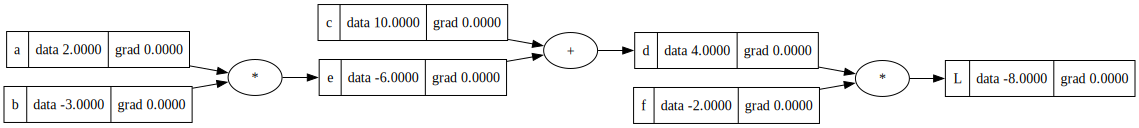

In [2168]:
# 图示跟踪结果
draw_dot(L)

In [2169]:
# 手动计算各值的梯度
h = 0.001
derivative_f = ((f.data+h)*d.data - f.data*d.data)/h
print(f"derivate dL/df = {derivative_f}")
#计算自己对自己的梯度为1
L.grad = 1
f.grad = 4
d.grad = -2
# dL/dd = -2
# dd/dc = 1 dd/de = 1
# dL/dc = (dL/dd) * (dd/dc) = -2 dL/de = (dL/dd) * (dd/de)
# why derivate chain rule use multiply, like bicycle speed is twice than human, car speed is four times than bicycle, so car speed is eight times than human.
c.grad = -2
e.grad = -2
# dL/da = dL/de * de/da = -2*b = -2*-3
a.grad = e.grad * b.data
b.grad = e.grad * a.data

derivate dL/df = 3.9999999999995595


In [2170]:
# prove it
# 通过导数定义计算a点相对与L的导数
def lol():
    h = 0.001;
    
    a = Value(2.0,label='a')
   
    b = Value(-3.0,label='b')
    c = Value(10,label="c")
    e = a*b
    e.label = "e"
    d = e+c
    d.label = 'd'
    f = Value(-2.0,label="f")
    L1 = f*d
    L1.label = "L1"
    
    a = Value(2.0,label='a')
    a.data+=h;
    b = Value(-3.0,label='b')
    c = Value(10,label="c")
    e = a*b
    e.label = "e"
    d = e+c
    d.label = 'd'
    f = Value(-2.0,label="f")
    L2 = f*d
    L2.label = "L2"
    return (L2.data-L1.data)/h

# caculate dL/da
lol()

6.000000000000227

In [2171]:
# adjust data see how grad influence result
# 通过观测调整变量值在梯度方向进行移动时如何影响函数结果的
step = 0.01
# a.data+=step*a.grad
# b.data+=step*b.grad
c.data+=step*c.grad
# f.data+=step*f.grad

L3 = (a*b+c)*f
L3

Value(data=-7.960000000000001)

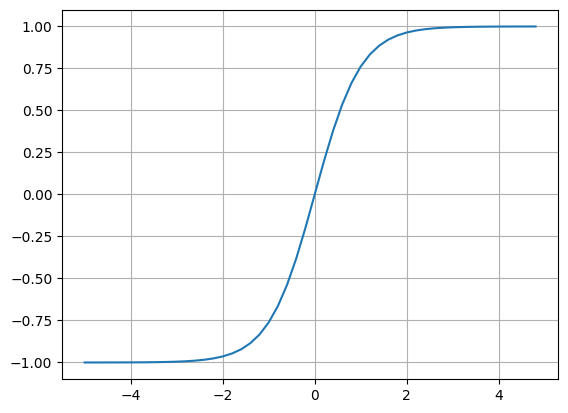

In [2172]:
# show the active function
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)));
plt.grid()

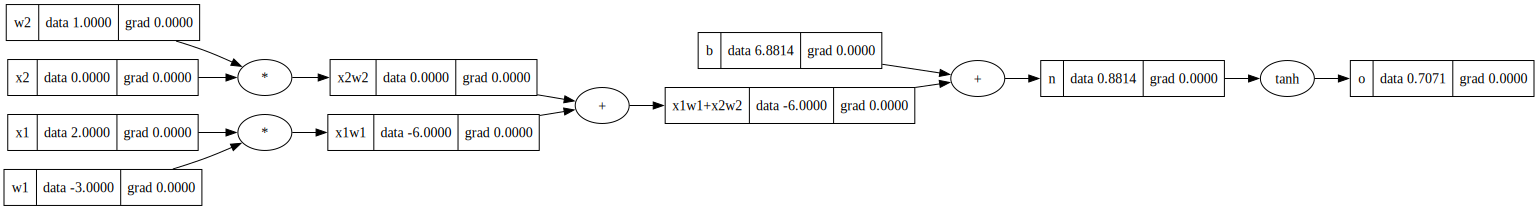

In [2173]:
# simulate neural network
# inputs x1,x2
# 模拟神经元，两个输入信号x1,x2，对应输入信号的权重w1,w2
# 使用tanh作为激活函数，将神经元的输出控制在[-1,1]的范围，防止输出数据范围过大，造成稀疏
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
# bias变量表示神经元本身的固有兴奋基础值，越高的基础值代表该神经元更容易被激活可以在接收到较小的刺激(输入数据)即输入更高的值
b = Value(6.88137,label='b')
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2+b
n.label = 'n'
o = n.tanh()
o.label = 'o'

draw_dot(o)

In [2174]:
# caculate the grad by manually, back propagation
# 手动计算各点的梯度
# o.grad = 1.0
# # according the caculus rules
# d_tanh = 1-o.data**2
# n.grad = d_tanh
# b.grad = 1*n.grad
# x1w1x2w2.grad = n.grad * 1
# x1w1.grad = x1w1x2w2.grad *1
# x2w2.grad = x1w1x2w2.grad *1
# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data
# x1.grad = x1w1.grad * w1.data
# w1.grad = x1w1.grad * x1.data

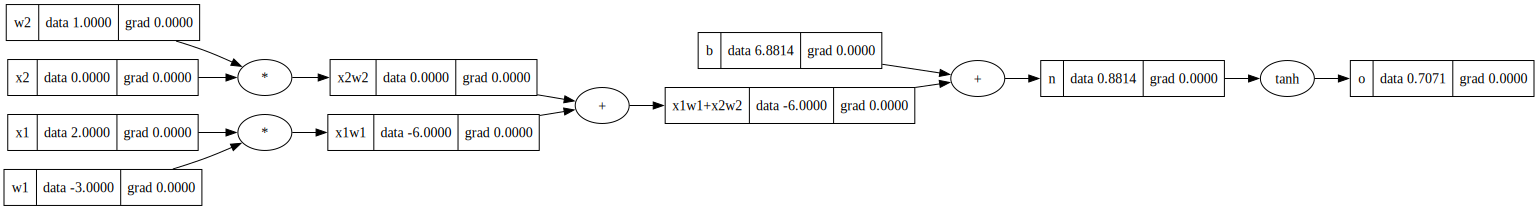

In [2175]:
draw_dot(o)

In [2176]:
# set the backward function to caculate the grad in Value class

In [2177]:
# initialize the root grad
# 反向计算首先要对结果梯度初始化，然后再往前计算其梯度
o.grad =1.0

In [2178]:
# o._backward()

In [2179]:
# n._backward()

In [2180]:
# x1w1x2w2._backward()

In [2181]:
# b._backward()

In [2182]:
# x1w1._backward()

In [2183]:
# x2w2._backward()

In [2184]:
# x1._backward();x2._backward()

In [2185]:
# w1._backward();w2._backward()

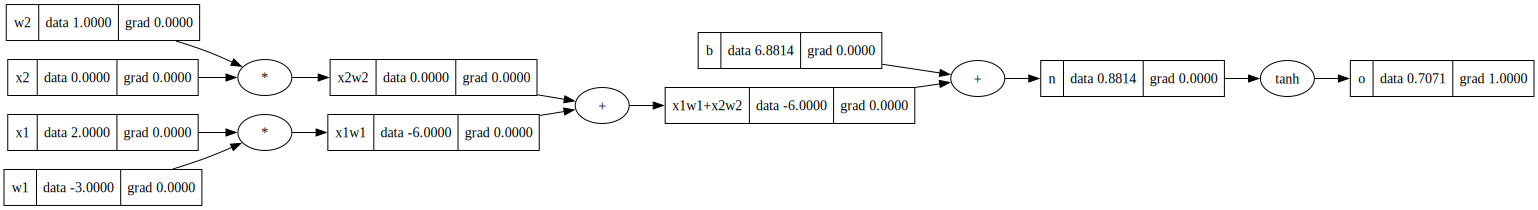

In [2186]:
draw_dot(o)

In [2187]:
# traverse all the node for caculate it's grad
# 通过递归按顺序遍历参与计算的全部节点
topo = []
visited = set()
def build_topo(node):
    if node not in visited:   
        visited.add(node)
        for child in node._prev:
            build_topo(child)
        topo.append(node)
build_topo(o)
topo

[Value(label=b  data=6.88137),
 Value(label=w1  data=-3.0),
 Value(label=x1  data=2.0),
 Value(label=x1w1  data=-6.0),
 Value(label=w2  data=1.0),
 Value(label=x2  data=0.0),
 Value(label=x2w2  data=0.0),
 Value(label=x1w1+x2w2  data=-6.0),
 Value(label=n  data=0.8813700000000004),
 Value(label=o  data=0.7071049876722272)]

In [2188]:
# traverse all the node for caculate it's grad
# 遍历的错误示范，提前存储了节点导致节点的存储顺序错误
topo_error = []
visited_error = set()
def build_topo_error(node):
    if node not in visited_error:   
        visited_error.add(node)
        topo_error.append(node)
        for child in node._prev:
            build_topo_error(child)
        
build_topo_error(o)
topo_error

[Value(label=o  data=0.7071049876722272),
 Value(label=n  data=0.8813700000000004),
 Value(label=b  data=6.88137),
 Value(label=x1w1+x2w2  data=-6.0),
 Value(label=x1w1  data=-6.0),
 Value(label=w1  data=-3.0),
 Value(label=x1  data=2.0),
 Value(label=x2w2  data=0.0),
 Value(label=w2  data=1.0),
 Value(label=x2  data=0.0)]

In [2189]:
# o.grad = 1.0
# for node in topo:
#     node._backward()

In [2190]:
# build own backward
# 将上述遍历算法存入对象中实现从结果的反向传播计算
o.backward()

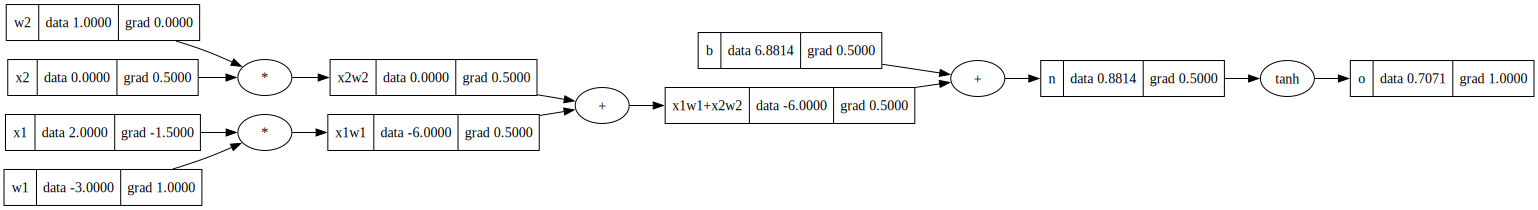

In [2191]:
draw_dot(o)

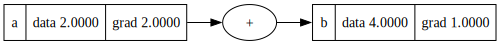

In [2192]:
# fix a bug about use same variable multiple
# to solve this problem, just refrence the mutiple variables in caculus, accumalate it's grad
# 解决当同一个变量参与了多次计算的问题，需要修改Value类中操作符中反向传播计算梯度时使用累加来解决bug
a= Value(2.0,label='a')
b = a+a
b.label = 'b'
b.backward()
draw_dot(b)

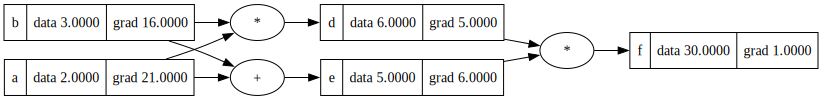

In [2193]:
# this is another example
# 这是另一个关于为什么要进行梯度累加的例子
a = Value(2,label='a')
b = Value(3,label='b')
d = a*b;d.label = 'd'
e = a+b;e.label = 'e'
f = d*e;f.label = 'f'
f.backward()
draw_dot(f)

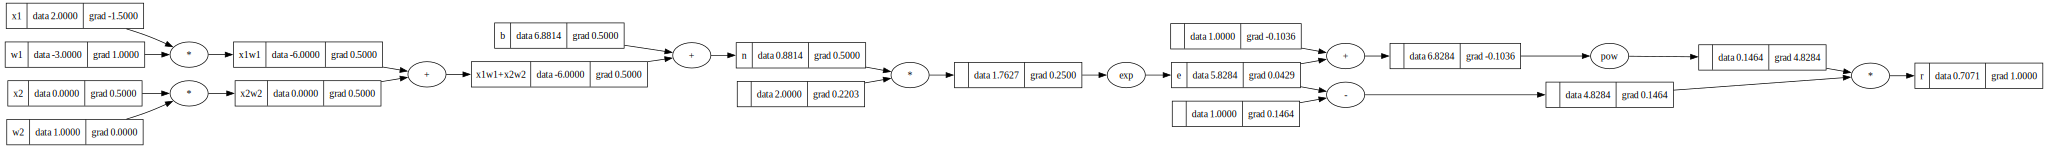

In [2194]:
# simulate neural network, make tanh function explict atom
# 因为tanh可以被分解为更基础的数学计算公式因此将其进行分解
# inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
b = Value(6.88137,label='b')
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2+b
n.label = 'n'
# r = n.tanh()
# r.label='r'
#--------
e = (2.0*n).exp()
e.label = 'e'
w = Value(1,label='w')
v = Value(-1,label='v')
r = (e-1)/(e+1)
#--------
r.label='r'

r.backward()

draw_dot(r)

In [2195]:
# 正确遍历函数
topo = []
visited = set()
build_topo(r)
topo

[Value(data=1),
 Value(data=2.0),
 Value(label=x2  data=0.0),
 Value(label=w2  data=1.0),
 Value(label=x2w2  data=0.0),
 Value(label=w1  data=-3.0),
 Value(label=x1  data=2.0),
 Value(label=x1w1  data=-6.0),
 Value(label=x1w1+x2w2  data=-6.0),
 Value(label=b  data=6.88137),
 Value(label=n  data=0.8813700000000004),
 Value(data=1.7627400000000009),
 Value(label=e  data=5.828385311532177),
 Value(data=6.828385311532177),
 Value(data=0.14644750616388644),
 Value(data=1),
 Value(data=4.828385311532177),
 Value(label=r  data=0.7071049876722272)]

In [2196]:
# 错误的遍历函数
topo_error = []
visited_error = set()
build_topo_error(r)
topo_error

[Value(label=r  data=0.7071049876722272),
 Value(data=0.14644750616388644),
 Value(data=6.828385311532177),
 Value(data=1),
 Value(label=e  data=5.828385311532177),
 Value(data=1.7627400000000009),
 Value(data=2.0),
 Value(label=n  data=0.8813700000000004),
 Value(label=x1w1+x2w2  data=-6.0),
 Value(label=x2w2  data=0.0),
 Value(label=x2  data=0.0),
 Value(label=w2  data=1.0),
 Value(label=x1w1  data=-6.0),
 Value(label=w1  data=-3.0),
 Value(label=x1  data=2.0),
 Value(label=b  data=6.88137),
 Value(data=4.828385311532177),
 Value(data=1)]

In [2197]:
import torch

In [2198]:
x = torch.Tensor([2.0]).double()
x.item()

2.0

In [2199]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.88137]).double()
n = x1*w1+x2*w2 + b
o = torch.tanh(n)
print(f'the result of o is {o.data.item()}')
o.backward()
print(f'the grad of x1 is {x1.grad.item()}')
print(f'the grad of w1 is {w1.grad.item()}')
print(f'the grad of x2 is {x2.grad.item()}')
print(f'the grad of w2 is {w2.grad.item()}')

the result of o is 0.7071050214706146
the grad of x1 is -1.500007465833125
the grad of w1 is 1.0000049772220834
the grad of x2 is 0.5000024886110417
the grad of w2 is 0.0


In [2200]:
import random

In [2206]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        # print(list(zip(self.w,x)))
        active = sum(wi*xi for wi,xi in zip(self.w,x))+self.b
        out = active.tanh()
        return out

class Layer:
    # nin 表示层内的每个神经元接受多少个输入,nout表示该层有多少个输出结果即有多少个神经元
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(sz)-1)]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
n = Neuron(3)
o = n([10,20,30])

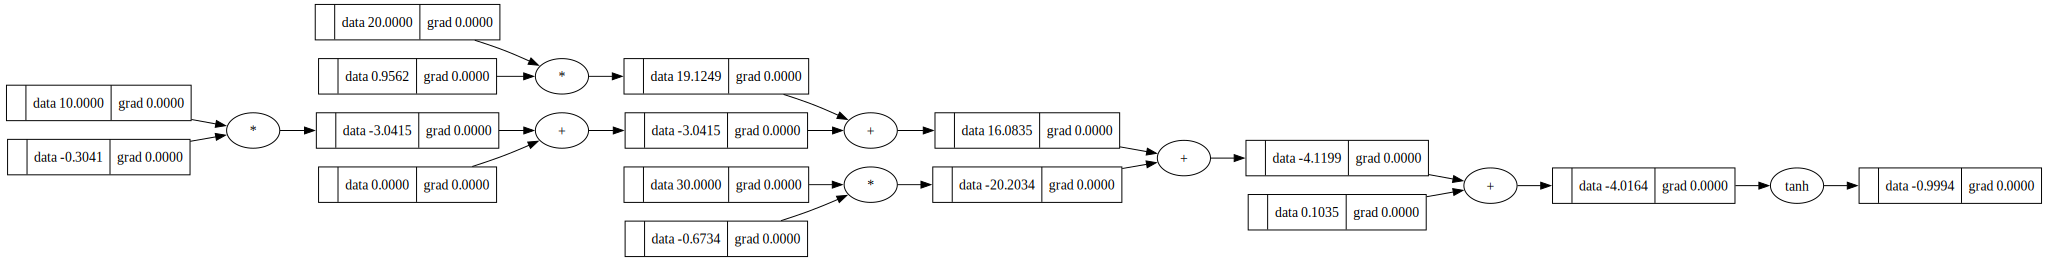

In [2203]:
draw_dot(o)

In [2230]:
n = Layer(2,3)
l = n([10,20])
m = Layer(3,1)
o = m(l)

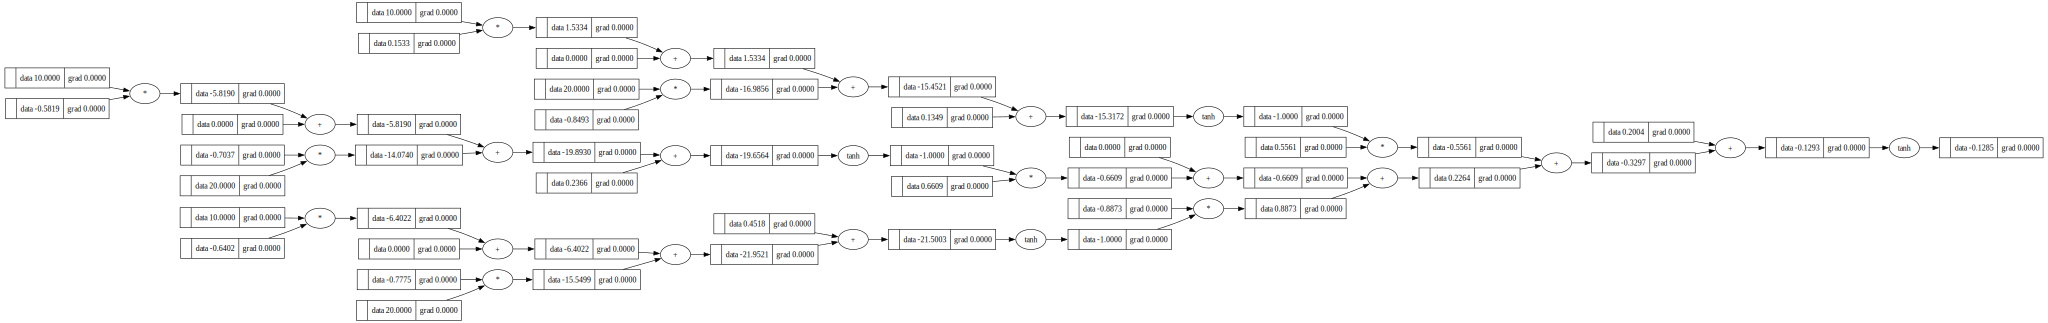

In [2231]:
draw_dot(o)

In [2223]:
m = MLP(3,[4,4,1])
x = [11,22,33]
o = m(x)
o

Value(data=0.825241929381842)

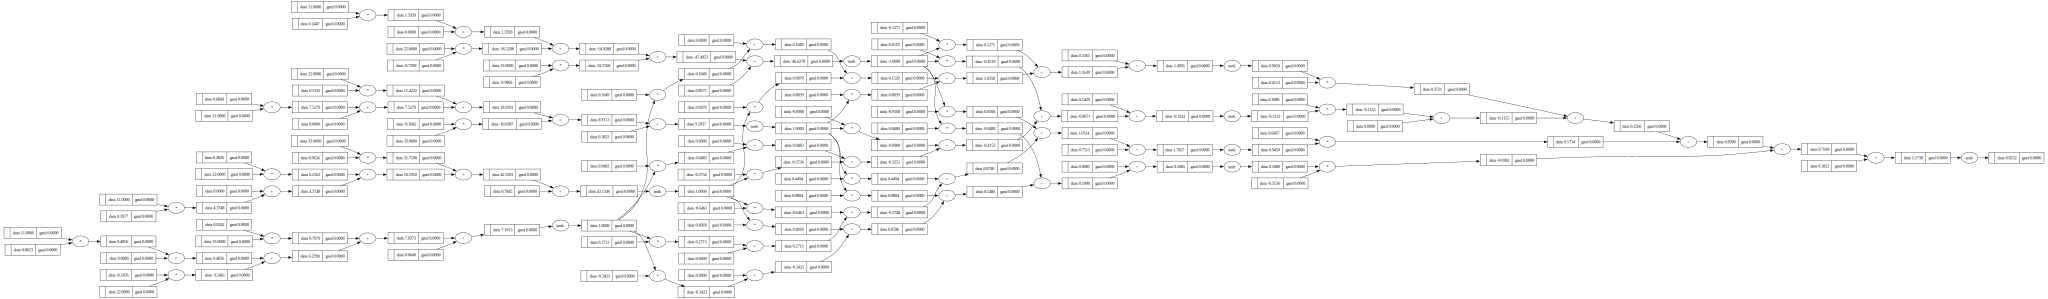

In [2224]:
draw_dot(o)